In [21]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [3]:
# Path to your manually extracted LFW folder
extract_path = r".\lfw\lfw-deepfunneled"

# Confirm the directory
print(f"Images are inside: {extract_path}")

# Find all images: look for *.jpg inside all person folders
image_paths = glob(os.path.join(extract_path, '*', '*.jpg'))
print(f"Total images found: {len(image_paths)}")

# Optional: print first 5 image paths to check
print("Sample image paths:", image_paths[:5])

Images are inside: .\lfw\lfw-deepfunneled
Total images found: 13233
Sample image paths: ['.\\lfw\\lfw-deepfunneled\\Aaron_Eckhart\\Aaron_Eckhart_0001.jpg', '.\\lfw\\lfw-deepfunneled\\Aaron_Guiel\\Aaron_Guiel_0001.jpg', '.\\lfw\\lfw-deepfunneled\\Aaron_Patterson\\Aaron_Patterson_0001.jpg', '.\\lfw\\lfw-deepfunneled\\Aaron_Peirsol\\Aaron_Peirsol_0001.jpg', '.\\lfw\\lfw-deepfunneled\\Aaron_Peirsol\\Aaron_Peirsol_0002.jpg']


In [4]:
# Build Human DataFrame
data = []
label = '1' # for human 
for path in image_paths:
    data.append((path, label))

human_df = pd.DataFrame(data, columns=['filepath', 'label'])
print(human_df.head())

# Check number of people and sample counts
print(f"Unique people: {human_df['label'].nunique()}")
print(human_df['label'].value_counts().head())


                                            filepath label
0  .\lfw\lfw-deepfunneled\Aaron_Eckhart\Aaron_Eck...     1
1  .\lfw\lfw-deepfunneled\Aaron_Guiel\Aaron_Guiel...     1
2  .\lfw\lfw-deepfunneled\Aaron_Patterson\Aaron_P...     1
3  .\lfw\lfw-deepfunneled\Aaron_Peirsol\Aaron_Pei...     1
4  .\lfw\lfw-deepfunneled\Aaron_Peirsol\Aaron_Pei...     1
Unique people: 1
label
1    13233
Name: count, dtype: int64


In [5]:
# Path to your manually extracted LFW folder
obj_extract_path = r".\tiny-imagenet-200\train" 

# Confirm the directory
print(f"Objects are inside: {obj_extract_path}")

# Find all images: look for *.jpg inside all person folders
objects_paths = glob(os.path.join(obj_extract_path, '*','*','*.jpeg'))
print(f"Total images found: {len(objects_paths)}")

# Optional: print first 5 image paths to check
print("Sample image paths:", objects_paths[:5])

Objects are inside: .\tiny-imagenet-200\train
Total images found: 100000
Sample image paths: ['.\\tiny-imagenet-200\\train\\n01443537\\images\\n01443537_0.JPEG', '.\\tiny-imagenet-200\\train\\n01443537\\images\\n01443537_1.JPEG', '.\\tiny-imagenet-200\\train\\n01443537\\images\\n01443537_10.JPEG', '.\\tiny-imagenet-200\\train\\n01443537\\images\\n01443537_100.JPEG', '.\\tiny-imagenet-200\\train\\n01443537\\images\\n01443537_101.JPEG']


In [6]:
# Build objects DataFrame
data = []
label = '0' # for objects
for path in objects_paths:
    data.append((path, label))

objects_df = pd.DataFrame(data, columns=['filepath', 'label'])
print(objects_df.head())

# Check number of people and sample counts
print(objects_df['label'].value_counts().head())


                                            filepath label
0  .\tiny-imagenet-200\train\n01443537\images\n01...     0
1  .\tiny-imagenet-200\train\n01443537\images\n01...     0
2  .\tiny-imagenet-200\train\n01443537\images\n01...     0
3  .\tiny-imagenet-200\train\n01443537\images\n01...     0
4  .\tiny-imagenet-200\train\n01443537\images\n01...     0
label
0    100000
Name: count, dtype: int64


In [7]:
# Shuffle the DataFrame
shuffled_df = objects_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Take first 50,000 rows
subset_df = shuffled_df.iloc[:30000]

print(subset_df.head())
print(f"Subset size: {len(subset_df)}")

                                            filepath label
0  .\tiny-imagenet-200\train\n04265275\images\n04...     0
1  .\tiny-imagenet-200\train\n04398044\images\n04...     0
2  .\tiny-imagenet-200\train\n02226429\images\n02...     0
3  .\tiny-imagenet-200\train\n04285008\images\n04...     0
4  .\tiny-imagenet-200\train\n07734744\images\n07...     0
Subset size: 30000


In [8]:
# Merge Both DataSets
combined_df = pd.concat([human_df, subset_df], ignore_index=True)
print(f"Combined samples: {len(combined_df)}")

Combined samples: 43233


In [9]:
# Shuffle the combined DataFrame
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the result
print(combined_df.head())
print(combined_df['label'].value_counts())  # Should show counts for 0 (object) and 1 (human)

                                            filepath label
0  .\lfw\lfw-deepfunneled\Mike_Miller\Mike_Miller...     1
1  .\tiny-imagenet-200\train\n02423022\images\n02...     0
2  .\tiny-imagenet-200\train\n02802426\images\n02...     0
3  .\tiny-imagenet-200\train\n03388043\images\n03...     0
4  .\tiny-imagenet-200\train\n03100240\images\n03...     0
label
0    30000
1    13233
Name: count, dtype: int64


In [10]:
# First split: Train + Temp (Temp = Val + Test)
train_df, temp_df = train_test_split(
    combined_df,
    test_size=0.3,  # 30% will be split again into val & test
    stratify=combined_df['label'],
    random_state=42
)

# Second split: Temp -> Validation + Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # half goes to test, half to val
    stratify=temp_df['label'],
    random_state=42
)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Train samples: 30263
Validation samples: 6485
Test samples: 6485


In [11]:
# ImageDataGenerator for training with basic augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

# For validation and test: only rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE = (224, 224)


In [12]:
# Training generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Validation generator
val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Test generator
test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 30263 validated image filenames belonging to 2 classes.
Found 6485 validated image filenames belonging to 2 classes.
Found 6485 validated image filenames belonging to 2 classes.


In [13]:
# Load the base model without top layer
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,  # drop final Dense layers
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False  # (or True if you want full fine-tuning)

In [14]:
# Add custom classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classifier: face vs object
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
EPOCHS = 3      # no. of Epochs

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


c:\Users\Kimo Store\anaconda3\envs\test\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 622s 652ms/step - accuracy: 0.9940 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 7.0522e-06
Epoch 2/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 579s 612ms/step - accuracy: 0.9998 - loss: 5.0177e-04 - val_accuracy: 1.0000 - val_loss: 1.6057e-05
Epoch 3/3
946/946 ━━━━━━━━━━━━━━━━━━━━ 558s 590ms/step - accuracy: 1.0000 - loss: 1.6953e-04 - val_accuracy: 1.0000 - val_loss: 1.2917e-09


c:\Users\Kimo Store\anaconda3\envs\test\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 74s 358ms/step


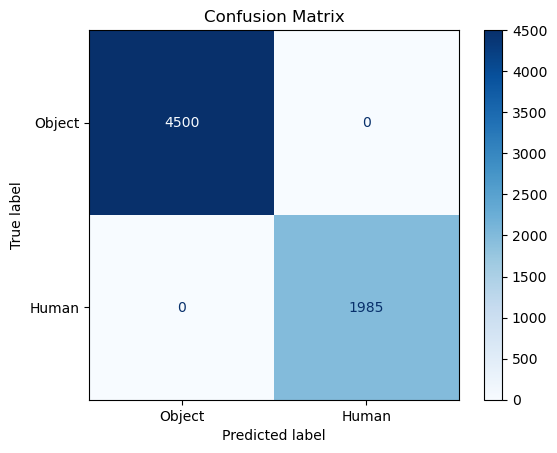

              precision    recall  f1-score   support

      Object       1.00      1.00      1.00      4500
       Human       1.00      1.00      1.00      1985

    accuracy                           1.00      6485
   macro avg       1.00      1.00      1.00      6485
weighted avg       1.00      1.00      1.00      6485



In [16]:
# Predict on test data
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs.flatten() > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Object', 'Human'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Object', 'Human']))


In [19]:
# Save as a TensorFlow SavedModel directory (recommended format)
model.save('my_mobilenetv2_classifier.keras')

# Or save as a single HDF5 file
model.save('my_mobilenetv2_classifier.h5')

In [24]:
# --- Get true labels ---
y_true = test_gen.classes
print(f"Total true labels: {len(y_true)}")

Total true labels: 6485


In [25]:
# FGSM setup 
loss_object = tf.keras.losses.BinaryCrossentropy()
epsilon = 0.01  # perturbation size

y_clean = []
y_adv = []

# Loop through batches
test_gen.reset()

for batch_idx, (images, labels) in enumerate(test_gen):
    images_tf = tf.convert_to_tensor(images)
    labels_tf = tf.convert_to_tensor(labels)

    # Clean predictions
    clean_preds = model(images_tf)
    clean_classes = (clean_preds.numpy().flatten() > 0.5).astype(int)
    y_clean.extend(clean_classes)

    # FGSM attack
    with tf.GradientTape() as tape:
        tape.watch(images_tf)
        preds = model(images_tf)
        loss = loss_object(labels_tf, preds)

    gradient = tape.gradient(loss, images_tf)
    signed_grad = tf.sign(gradient)
    adv_images = images_tf + epsilon * signed_grad
    adv_images = tf.clip_by_value(adv_images, 0, 1)

    # Adversarial predictions
    adv_preds = model.predict(adv_images)
    adv_classes = (adv_preds.flatten() > 0.5).astype(int)
    y_adv.extend(adv_classes)

    # Stop after full pass
    if batch_idx + 1 >= len(test_gen):
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
#Final consistency check
print(f"y_true: {len(y_true)}, y_clean: {len(y_clean)}, y_adv: {len(y_adv)}")

# Evaluate
print(f"Clean accuracy: {accuracy_score(y_true, y_clean):.4f}")
print(f"Adversarial accuracy: {accuracy_score(y_true, y_adv):.4f}")

print("\nAdversarial confusion matrix:")
print(confusion_matrix(y_true, y_adv))

y_true: 6485, y_clean: 6485, y_adv: 6485
Clean accuracy: 1.0000
Adversarial accuracy: 0.9113

Adversarial confusion matrix:
[[4436   64]
 [ 511 1474]]


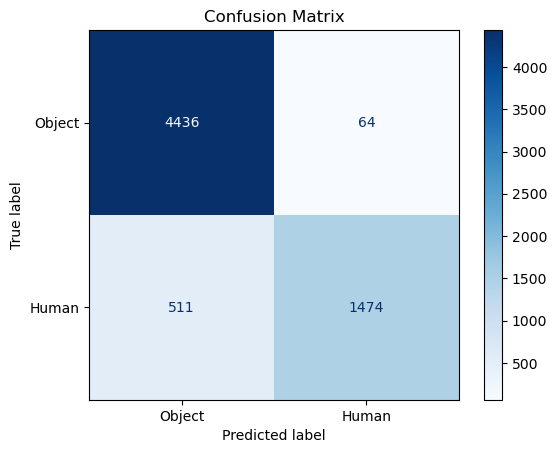

              precision    recall  f1-score   support

      Object       0.90      0.99      0.94      4500
       Human       0.96      0.74      0.84      1985

    accuracy                           0.91      6485
   macro avg       0.93      0.86      0.89      6485
weighted avg       0.92      0.91      0.91      6485



In [27]:
# Confusion matrix
cm = confusion_matrix(y_true, y_adv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Object', 'Human'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_adv, target_names=['Object', 'Human']))
